## Классификация заболеваний почек
* Были предоставлены изображения компьютерной томографии с 3-мя классами.

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import tensorflow as tf
import cv2

from PIL import Image, ImageOps
import scipy.ndimage as ndi

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import matplotlib.pyplot as plt

from skimage import transform
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import splitfolders

### Загрузка датасета

In [2]:
os.listdir(r'C:\Users\Daniil\Downloads\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')


['CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', 'kidneyData.csv']

In [3]:
os.listdir(r'C:\Users\Daniil\Downloads\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/')

['Cyst', 'Normal', 'Stone', 'Tumor']

In [4]:
path_main = r'C:\Users\Daniil\Downloads\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/'
for folder in os.listdir(path_main):
    list_of_elements = os.listdir(os.path.join(path_main, folder)) 
    print(f'Folder: {folder}\n')
    print(f'Number of elements: {len(list_of_elements)}\n')
    print(f'First item\'s name: {list_of_elements[0]}\n')
    print('***************************')

Folder: Cyst

Number of elements: 3709

First item's name: Cyst- (1).jpg

***************************
Folder: Normal

Number of elements: 5077

First item's name: Normal- (1).jpg

***************************
Folder: Stone

Number of elements: 1377

First item's name: Stone- (1).jpg

***************************
Folder: Tumor

Number of elements: 2283

First item's name: Tumor- (1).jpg

***************************


In [5]:
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()

In [6]:
path_normal = r'C:\Users\Daniil\Downloads\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/'
path_stone = r'C:\Users\Daniil\Downloads\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/'
path_cyst = r'C:\Users\Daniil\Downloads\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/'
path_tumor = r'C:\Users\Daniil\Downloads\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/'

### Камни

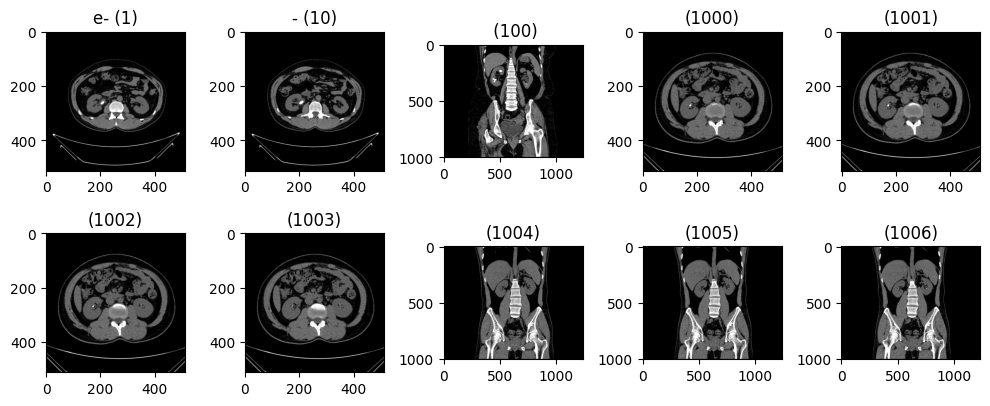

In [7]:
plot_imgs(path_stone, 10)

### Нормальные почки

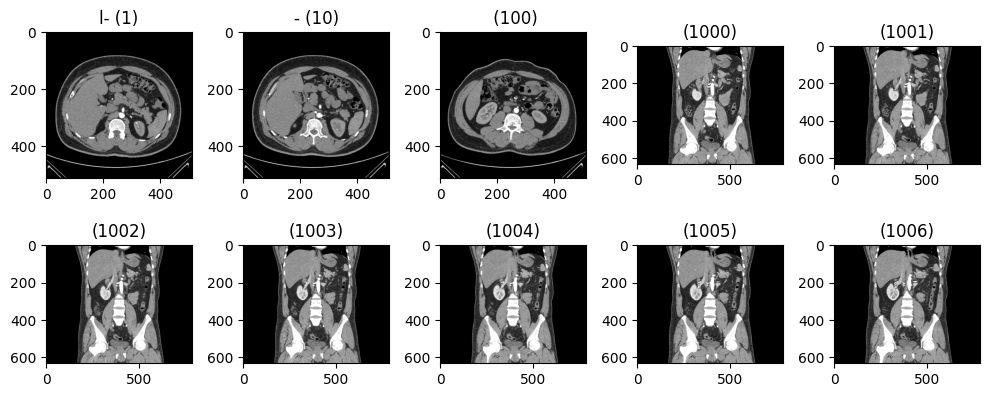

In [8]:
plot_imgs(path_normal, 10)

### Опухоли

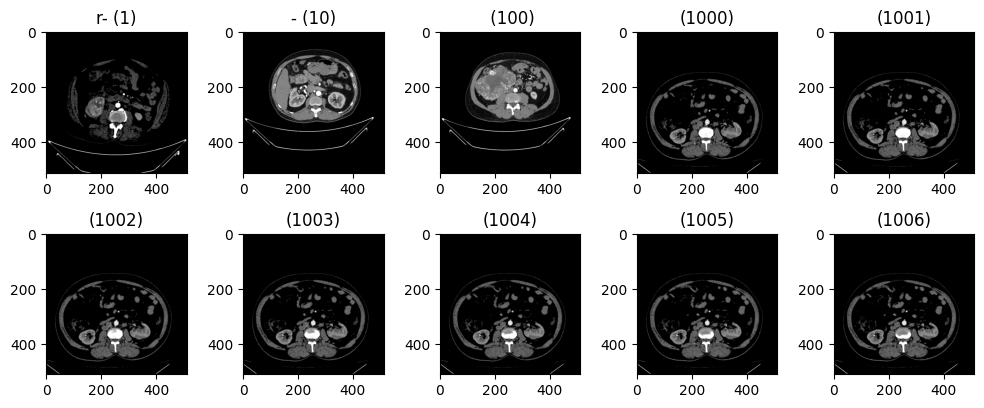

In [9]:
plot_imgs(path_tumor, 10)

### Киста

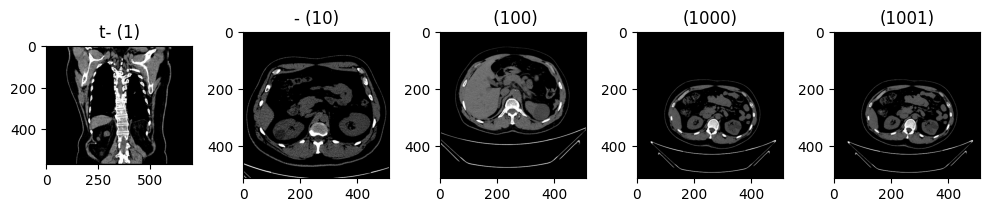

In [10]:
plot_imgs(path_cyst, 5)

## Разделение датасета

In [12]:
splitfolders.ratio(
    r"C:\Users\Daniil\Downloads\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/",
   output="./dataset",
   seed=7, #зерно для воспроизводимости
   ratio=(0.8,0.1, 0.1) # задать соотношение разделения данных: 80% для обучения, 10% для валидации и 10% для тестирования
)

## Рескейлинг

In [13]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [14]:
train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


## Модель

In [25]:
# Создание модели Sequential (последовательной) нейронной сети
model = tf.keras.models.Sequential([
  
    # Слой свертки с 32 фильтрами размера (3, 3), функцией активации ReLU
    # и паддингом 'same' для сохранения размерности, входной формы задается через train_dataset.image_shape
    tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=train_dataset.image_shape), 

    # Слой максимальной пулинга с размером пула (2, 2)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Слой свертки с 64 фильтрами размера (3, 3), функцией активации ReLU и паддингом 'same'
    tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'),

    # Слой максимальной пулинга с размером пула (2, 2)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Слой свертки с 128 фильтрами размера (3, 3), функцией активации ReLU и паддингом 'same'
    tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'),

    # Слой максимальной пулинга с размером пула (2, 2)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Слой свертки с 256 фильтрами размера (3, 3), функцией активации ReLU и паддингом 'same'
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),

    # Слой максимальной пулинга с размером пула (2, 2)
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Слой "сплющивания" данных перед подачей их в полносвязные слои
    tf.keras.layers.Flatten(),

    # Полносвязный слой с 128 нейронами и функцией активации ReLU
    tf.keras.layers.Dense(128, activation='relu'),

    # Полносвязный слой с 64 нейронами и функцией активации ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Полносвязный выходной слой с 4 нейронами и функцией активации softmax для классификации
    tf.keras.layers.Dense(4, activation='softmax')
])

In [26]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [27]:
# Учимся
model_fit = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch = 6,
                      epochs = 50)

Epoch 1/50
6/6 [==============================] - 18s 3s/step - loss: 1.3983 - accuracy: 0.3683 - precision: 0.4382 - recall: 0.0650 - val_loss: 1.2824 - val_accuracy: 0.4082 - val_precision: 0.6543 - val_recall: 0.3688
Epoch 2/50
6/6 [==============================] - 17s 3s/step - loss: 1.2512 - accuracy: 0.4600 - precision: 0.5855 - recall: 0.2283 - val_loss: 1.2584 - val_accuracy: 0.4984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 17s 3s/step - loss: 1.3442 - accuracy: 0.4767 - precision: 0.4407 - recall: 0.0867 - val_loss: 1.2958 - val_accuracy: 0.5040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
6/6 [==============================] - 16s 3s/step - loss: 1.2370 - accuracy: 0.5017 - precision: 0.6080 - recall: 0.1267 - val_loss: 1.2056 - val_accuracy: 0.4227 - val_precision: 0.8328 - val_recall: 0.2126
Epoch 5/50
6/6 [==============================] - 16s 3s/step - loss: 1.2023 - accuracy: 0.4883 - precis

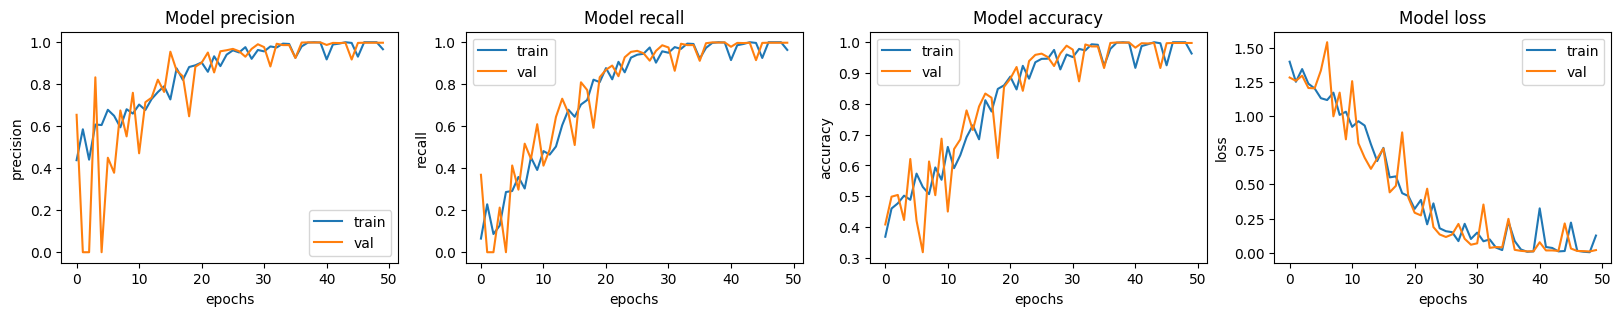

In [28]:
# Инфографика крч
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(model_fit.history[met])
    ax[i].plot(model_fit.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
predictions = model.predict(test_dataset)

13/13 [==============================] - 7s 521ms/step


In [30]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [31]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(20,20))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.9991993594875901
Precision: 0.9995098039215686
Recall: 0.9982014388489209
F1_score: 0.998852134356965


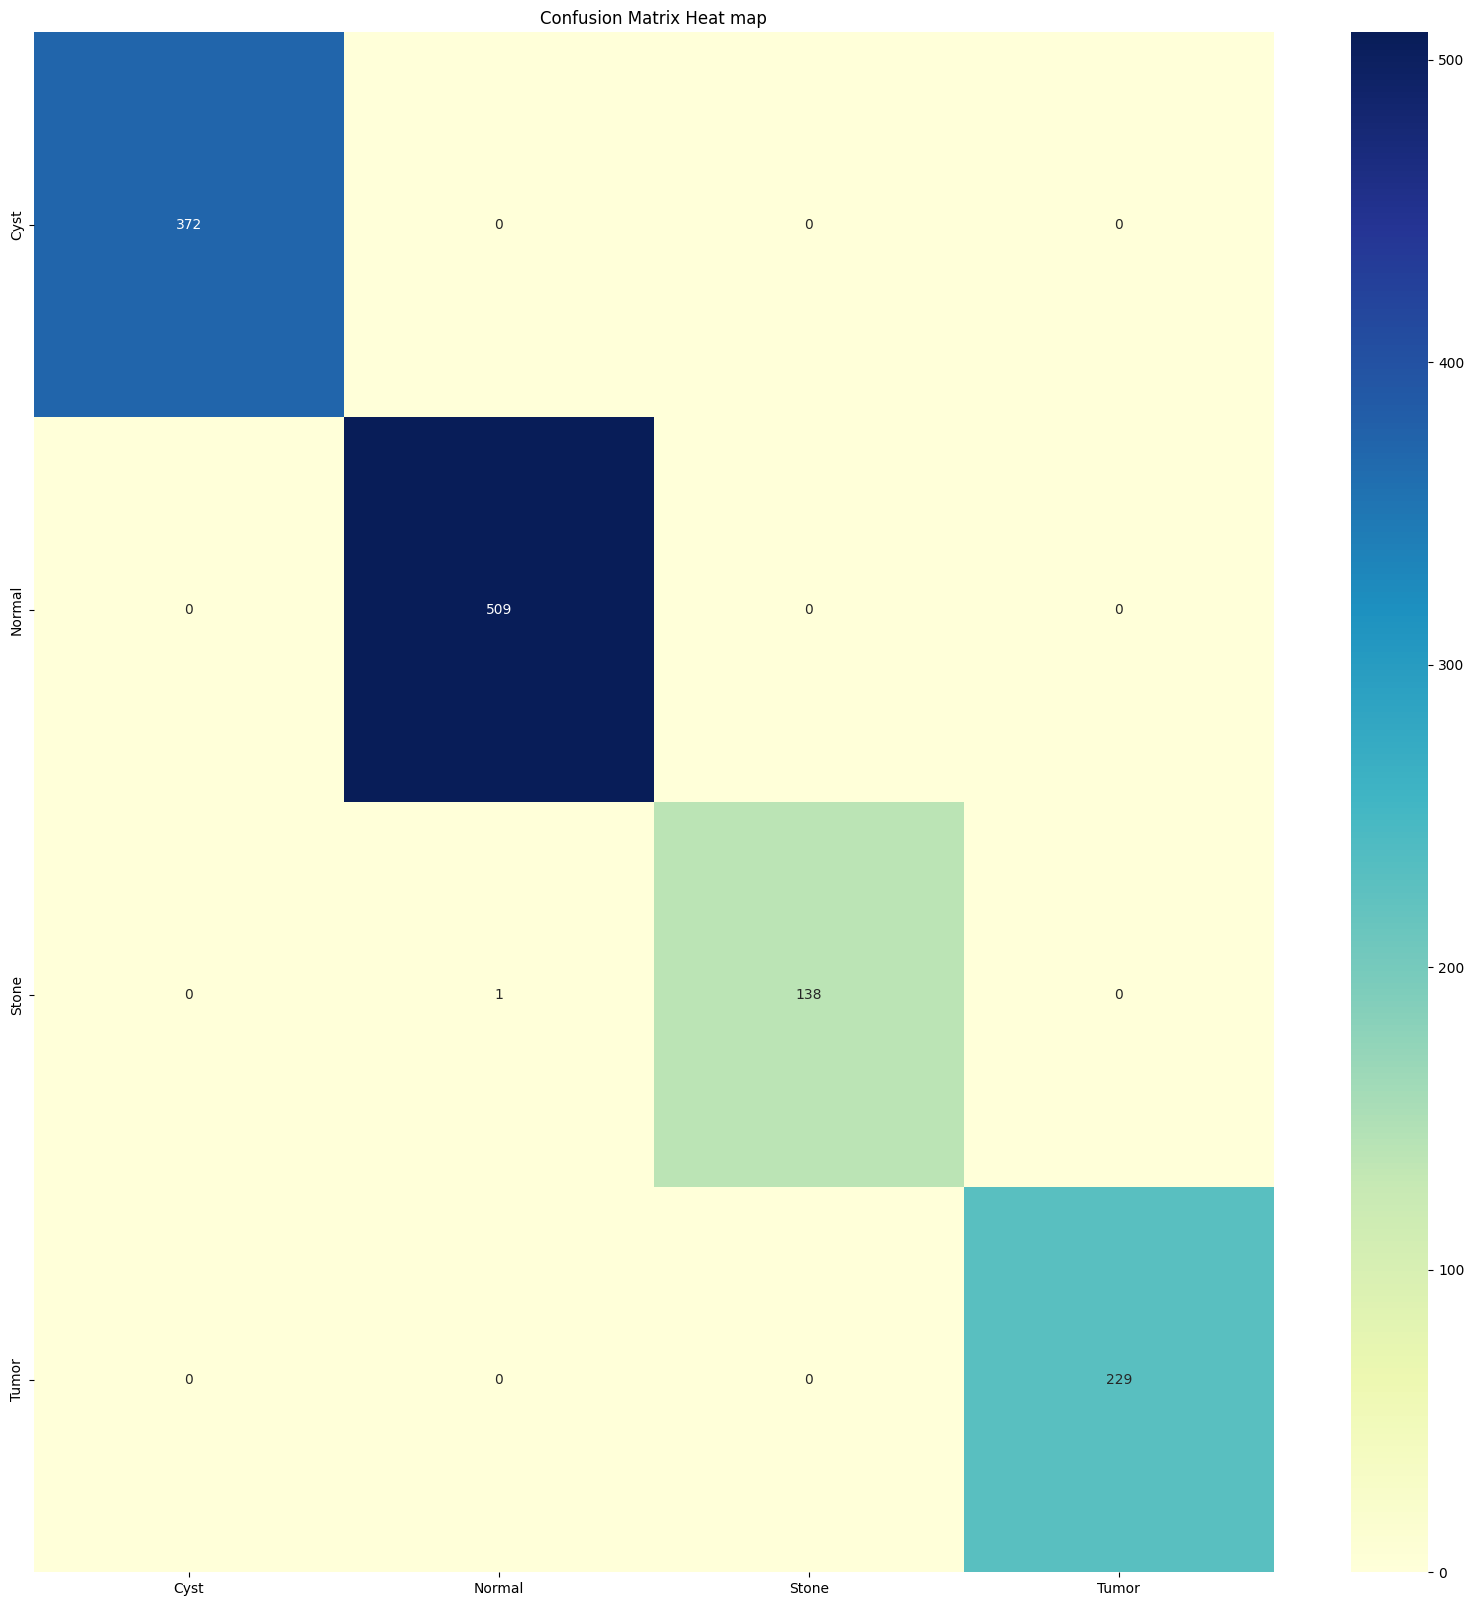

In [32]:
# Инфографика крч ч.2
evaluate(test_dataset.classes,predictions)

In [33]:
model.evaluate(test_dataset)


13/13 [==============================] - 7s 513ms/step - loss: 0.0185 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992


[0.018501047044992447,
 0.9991993308067322,
 0.9991993308067322,
 0.9991993308067322]

In [ ]:
# Сейвим модель
model.save("name.h5") 